# TP QP par un algorithme de points intérieurs

In [10]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.svm import SVC
import scipy as sp
from scipy import optimize


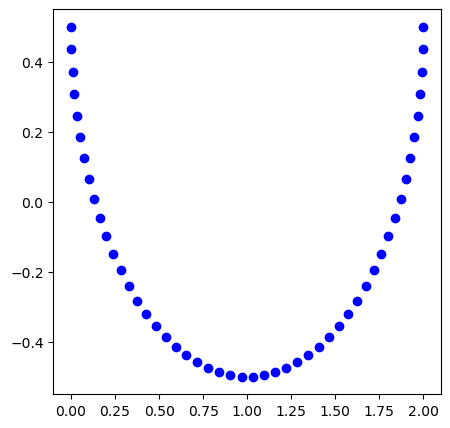

In [11]:
n_train = 100
X,y = make_moons(n_samples=100, shuffle=True, noise=None, random_state=None)
y = np.where(y > 0.5, y, -1)

# afficher les données d'apprentissage sur un plot avec une couleur par classe
# inserer votre code ici

colors =['r','b']

plt.figure(figsize=(5,5))
for k in range(len(np.unique(y))):
    plt.plot(X[y==k,0],X[y==k,1],colors[k]+'o',markersize=4,markeredgewidth=3)
plt.show()

In [ ]:
#%% SVM dual 
C =1000
N = X.shape[0]

from sklearn.metrics.pairwise import rbf_kernel
gamma = 1
N = X.shape[0]
K = rbf_kernel(X,gamma = gamma)
yb = y.reshape(N,1)
P = K*(yb@yb.T)
q = -np.ones(N)

clf = SVC(C=C,kernel='precomputed')
clf.fit(K, y)
indice_SV = clf.support_
alpha_sk = clf.dual_coef_[0]
b_sk = clf.intercept_

# construire le vecteur solution alpha_0

# %% 
alpha_o = np.zeros(N)
xo = alpha_o
alpha_o[indice_SV] = np.abs(alpha_sk)

# calculer la valeur objective optimale du problème QP obtenu par ce solveur SVM
# et afficher le résultat

cout_optmal_SVM = 0.5*alpha_o.T@P@xo + q.T@alpha_o

print('cout opt SVM',cout_optmal_SVM)


cout opt -16.618071819892787


On s'interesse au problème
$$
\min_{\alpha} \frac{1}{2} \alpha^\top P \alpha + q^\top \alpha  \quad \text{ } \quad \text{sc } \quad \alpha^\top y = 0  \text{ et } \alpha \geq 0
$$

In [13]:
def Jacobienne(P, A, N, nb_constraint, Sk, Xk):
    J1 = np.hstack((P, -A.T, -np.eye(N)))
    J2 = np.hstack((A, np.zeros((nb_constraint, nb_constraint)), np.zeros((nb_constraint, N))))
    J3 = np.hstack((Sk, np.zeros((N, nb_constraint)), Xk))
    
    # construire la Jacobienne
    J = np.vstack((J1,J2,J3)) 

    return J

def Second_Membre(P, A, N, nb_constraint, Xk, sigma, tau, x, q, s):
    b1 = (P@x + q - s - (A.T@ll).flatten()).reshape(N, 1)
    b2 = (A@x - b).reshape(nb_constraint, 1)
    b3 = ((Xk@s) - sigma*tau*np.ones(N)).reshape(N, 1)

    second_membre = np.vstack((b1,b2,b3)) 
    return second_membre

def Deltas(S, N, nb_constraint):
    dx = S[:N].flatten()
    dy = S[N:N+nb_constraint].flatten()
    ds = S[N+nb_constraint:].flatten()
    
    return dx, dy, ds

def PasOptin(x, dx, s, ds):
    step = 1
    while (np.any(x + step*dx < 0) or np.any(s + step*ds < 0)):
        step = step*0.5
        
    return step

In [14]:
# Algorithme de point intérieur 

# construction du problème et des matrices associés

q = -np.ones(N)
b = np.array([0.0])
A = y.reshape(1,N)

# initialization du point intérieur

alpha = np.random.rand(N)*1e-2 #### X
nb_constraint = A.shape[0]

ll = np.ones((nb_constraint,1)) # multiplicateur de Lagrange ##### lambda
s = ((P@alpha + q).reshape(N,1) - A.T@ ll).reshape(N)
s = np.where(s < 0.000001, 1e-16, s)  # on garde que les parties positives pour que s soit faisable

cout_init = 0.5*alpha.T@P@alpha + q.T@alpha

print('cout init', cout_init)

x = alpha.copy()


cout init -0.46088127484897445


In [ ]:
tolerance = 1e-12
cost_values = [0.5 * alpha.T @ P @ alpha + q.T @ alpha]

for i in range(1000):
    tau = x@s/N
    Sk = np.diag(s)
    Xk = np.diag(x)
    sigma = 0.5

    # construire la Jacobienne
    J = Jacobienne(P, A, N, nb_constraint, Sk, Xk) 

    # # construire le second membre
    second_membre = Second_Membre(P, A, N, nb_constraint, Xk, sigma, tau, x, q, s)

    # résoudre le problème
    S = np.linalg.solve(J, -second_membre)
    
    # extraire les directions pour chaque partie
    dx, dy, ds = Deltas(S, N, nb_constraint)
    
    # définir le pas optimal 
    step = PasOptin(x, dx, s, ds)

    # mise à jour
    x = x + step*dx
    ll = ll + step*dy
    s = s + step*ds
    
    # calcul du Cout
    cost_values.append(0.5 * x.T @ P @ x + q.T @ x)
    
    # condition de sortie 
    if len(cost_values) > 1 and abs(cost_values[-1] - cost_values[-2]) < tolerance:
        print("Convergence réalisée")
        break

cout_optmal = cost_values[-1]

Convergence réalisée




1.   Montrer que le cout décroit correctement
2.   Comparer la solution alpha avec celui obtenu par le solveur SVM
3.   Améliorer la boucle pour avoir une condition de sortie plus pertinente





### 1. Montrer que le cout décroit correctement

Coût initial: -0.460881
Coût optimal: -16.618797


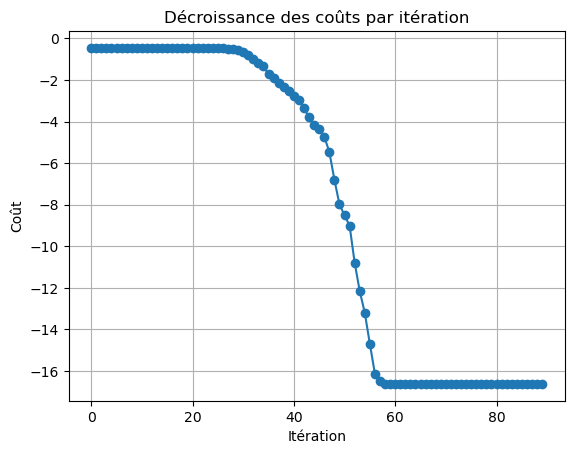

In [24]:
print(f"Coût initial: {cout_init:.6f}")
print(f"Coût optimal: {cout_optmal:.6f}")

plt.plot(cost_values, marker='o')
plt.xlabel("Itération")
plt.ylabel("Coût")
plt.title("Décroissance des coûts par itération")
plt.grid(True)
plt.show()

### 2. Comparer la solution alpha avec celui obtenu par le solveur SVM

In [22]:
diff_abs = abs(cout_optmal - cout_optmal_SVM)
rel_error = diff_abs / abs(cout_optmal_SVM)

print(f"Coût optimal SVM: {cout_optmal_SVM:.6f}")
print(f"Coût optimal: {cout_optmal:.6f}")
print(f"Divergence absolue: {diff_abs:.6f}")
print(f"Divergence relative: {rel_error:.4%}")


Coût optimal SVM: -16.618072
Coût optimal: -16.618797
Divergence absolue: 0.000725
Divergence relative: 0.0044%


### 3. Améliorer la boucle pour avoir une condition de sortie plus pertinente

> Pour améliorer la condition de sortie de la boucle et éviter d'atteindre le nombre maximal d'itérations, la différence entre les deux derniers valeurs de la fonction de coût est calculée, puis comparée à une valeur de tolérance (tolerance = 1e-12). Dans cette condition, si la différence est inférieure à la tolérance, le programme reconnaît la convergence de la méthode et interrompt l'exécution avec la commande break. Cela améliore l'efficacité de la méthode en évitant des calculs inutiles après avoir atteint un résultat suffisamment précis.

Modifier les matrices proposées en entrée de cette algorithme afin de résoudre le problème complet
$$
\min_{\alpha} \frac{1}{2} \alpha^\top P \alpha + q^\top \alpha  \quad \text{ } \quad \text{sc } \quad \alpha^\top y = 0  \text{ et } C \geq \alpha \geq 0
$$